# Turing Machine and Deep Learning 2023

## Assignment Unupervised ML

This notebook is meant for you to review and reflect on the content of Lecture 3, which was mainly about unsupervised learning problems. As with last week, this notebook should not be too much quantitative work (lines of code) but keep in mind that running this notebook may take a longer time than you may be used to for python programs (*training good models take time!*)

### Handing in your Assignment

Git is an invaluable resource to researchers and developers, and thus for this course, all course material will be (additionally) shared on GitHub. Though there is a tiny bit of a learning curve, this is worth the effort. To hand in your assignment (applicable to all weeks):

1. Create a folder called "Week 2" and copy this notebook and any other files or data that may be needed.
2. Finish the notebook and commit and push regularly. Your final commit before the deadline will be graded.


### Grading

Each one of the (sub-)questions below will be graded either 0 (insufficient), 1 (sufficient) or 2 (good). If $N$ is the number of sub-questions, and $p_i$ is your score for sub-question $i$, your total grade $G$ for this assignment is:
$$G=\frac{1}{2 N}\sum_{i=0}^{N}p_i$$

In [2]:
# load common libraries
import numpy as np                 # maths
import matplotlib.pyplot as plt    # plotting
import pandas as pd                # data manipulation
from tqdm import tqdm              # loading bar
from time import perf_counter      # timer

# Q1 Loading and preprocessing data

In this repository, you should find a file called `tmdb_5000_movies.csv` which is information from a subset of movies on The Movie Database.

### Q.1.1
Use pandas to read in the csv file (refer to [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) if you're unfamiliar).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Turing Machine Learning Course/Week 3 - PCA & Clustering/tmdb_5000_movies.csv")

View information about the dataset including datatypes and null values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

**Q.1.1.2** What columns have null values above? How would you be able to estimate the missing values?

The columns that have null values are:

*   Home page - missing 3091 observations
*   overview - missing 3 observations
*   realease date - missing 1 observation
*   runtime - missing 2 obervations
*   tagline - missing 844 observations

The only ones I would bother estimating are the numerical column runtime. I would estimate the 2 missing observations by giving them the average runtime of the sample.








### Q1.2
For this notebook, we're only interested in a few columns, specifically title, overview and genres. Set df to only contain those columns.

In [6]:
df = df[["title","overview","genres"]]
df.info() # print out df info to verify

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     4803 non-null   object
 1   overview  4800 non-null   object
 2   genres    4803 non-null   object
dtypes: object(3)
memory usage: 112.7+ KB


### Q1.3
We see that some movies do not have an overview. Drop them from the table and reset the index (set `drop=True`).

In [7]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

# Q2 One-hot encodings
The following code processes the genres (which you see above are list of dictionaries) and encodes them into one-hot labels.

Remember, since we cannot do maths on text strings, we must change these words to numbers. Here, we create one-hot encodings for the genres. Assume we have three genres $[G_1, G_2, G_3]$. If a movie $M_1$ is tagged with genre $G_1$, the encoding is $[1,0,0]$. If another movie $M_2$ is tagged with $G2$, the encoding becomes $[0,1,0]$. Other encodings are possible as well, but one-hot encoding quite common and useful for many other tasks. In this case, if a movie is tagged with more than one genre, we'll just take a random one and encode that into a one-hot label.

### Q2.1 Processing genres

Finish the following code that processes genres into one-hot encodings.

In [10]:
np.random.seed(0)

def process_genre_string(gs):
    """ Processes genres into a single item from a list"""
    gs = eval(gs)
    gs = [x['name'] for x in gs]
    genre = "Unknown"
    if gs:
        genre = np.random.choice(gs) # choose random entry
    return genre

# TODO: Fill in
def encode_labels(label, unique_labels):
    """ Encodes text labels into a one-hot encoded list
        with possibly more than one one-hot per list.
        :param label: the label you want to one-hot encode
        :unique_labels: the vocabulary
    """
    out = np.zeros(len(unique_labels))
    if label in unique_labels:
        index = unique_labels.index(label)
        out[index] = 1
    return out

# save genres
processed_genres = []
for index, row in df.iterrows():
    processed_genres.append(process_genre_string(row['genres']))

# sort and remove duplicates to get vocabulary
unique_genres = sorted(list(set(processed_genres)))

# add to dataframe as new column
df["proc_genres"] = processed_genres

# one-hot encode genres
enocded_labels = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    enocded_labels.append(encode_labels(row['proc_genres'], unique_genres))

df["one_hot_genres"] =  enocded_labels

100%|██████████| 4800/4800 [00:00<00:00, 19464.95it/s]


Verify that one-hot encodings are indeed as expected

In [11]:
df["one_hot_genres"][0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

### Q2.2 Processing Overviews
Next, we process the overviews. First, we remove all punctuation for the sake of simplicity and change each overview to use only lowercase. Then we need to see how long the overviews are in terms of numbers of words. We can do this with a histogram.

**Q2.2.1** Finish the following code

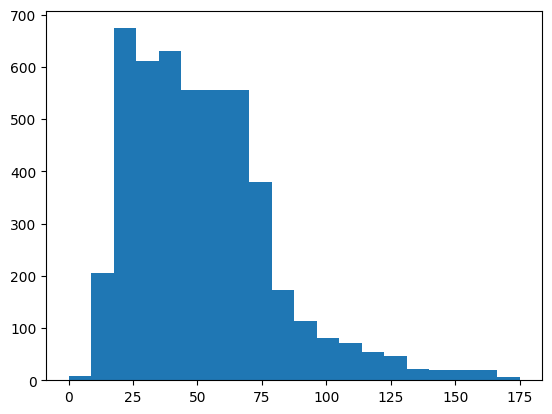

In [12]:
import re
def remove_punctuation(text):
    """ Only retains letters, numbers, underscores and whitespace """
    pattern = r'[^\w\s]'
    return re.sub(pattern, '', text)

processed_overviews = []

# loop over df, remove punctuation, make words lowercase and add it to a new column
for index, row in df.iterrows():
    processed_overviews.append(remove_punctuation(row['overview']).lower())

df["proc_overview"] = processed_overviews

# get the word lengths of each overview and store it in a list
overview_lens = [len(overview.split()) for overview in df["proc_overview"]]

# for the sake of simplicity, add these values as a column to the df
df["overview_len"] = overview_lens

plt.hist(overview_lens, bins=20)
plt.show()

**Q2.2.2** What is the shortest overview? What is the longest? In the next step, we need to decide on a standard length of all overviews -- this means dropping overviews less than some value, and truncating longer ones. What length would you choose to minimize the number of movies dropped and maximize the information (words) stored in the overviews?

The shortest overview has 0 words and the longest one has 175 words. I would choose the size of overview with the highest frequency (from what I see that is around 25 words).

### Q2.2.3
Let's choose overviews of length 15 words. What this means is we need to discard movies that have overviews less than 15 (there are other ways of dealing with it, but this should be fine for now) and truncate the higher ones to the first 15 words.

In [13]:
token_len = 15 # number of words
# only select rows where overview len is more than or equal to token_len
df = df[df['overview_len'] >= token_len]

# split each proc_overview into a list of words, select the first token_len words,
# and add the list of words back into df["proc_overview"]
df["proc_overview"] = [overview.split()[:token_len] for overview in df["proc_overview"]]

# print to verify
df

<ipython-input-13-54e3b938ee68>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["proc_overview"] = [overview.split()[:token_len] for overview in df["proc_overview"]]


,title,overview,genres,proc_genres,one_hot_genres,proc_overview,overview_len
0,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",Action,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[in, the, 22nd, century, a, paraplegic, marine...",28
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",Fantasy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[captain, barbossa, long, believed, to, be, de...",34
2,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",Action,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[a, cryptic, message, from, bonds, past, sends...",41
3,The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",Thriller,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[following, the, death, of, district, attorney...",65
4,John Carter,"John Carter is a war-weary, former military ca...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",Adventure,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[john, carter, is, a, warweary, former, milita...",55
...,...,...,...,...,...,...,...
4794,Cavite,"Adam, a security guard, travels from Californi...","[{""id"": 10769, ""name"": ""Foreign""}, {""id"": 53, ...",Thriller,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[adam, a, security, guard, travels, from, cali...",115
4795,El Mariachi,El Mariachi just wants to play his guitar and ...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",Crime,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[el, mariachi, just, wants, to, play, his, gui...",62
4797,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...","[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",TV Movie,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[signed, sealed, delivered, introduces, a, ded...",73
4798,Shanghai Calling,When ambitious New York attorney Sam is sent t...,[],Unknown,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[when, ambitious, new, york, attorney, sam, is...",65


### Q2.2.3 Finding the vocabulary length

In order to one-hot encode words, we need to find how many words there are in total, just like in the case of genres. Get all the words, remove duplicates, and sort. Find and print the length of your vocabulary.

In [14]:
# hint: store all words for all movies in a set, change it to a list and

setOfWords = set()
for overview in df["proc_overview"]:
    setOfWords.update(overview)

all_words_list = sorted(list(setOfWords))
vocab_len = len(all_words_list)
print(vocab_len)

12493


### Q2.2.4 Encoding the labels

In the case of genres, we one-hot encoded the outputs by taking a single random genre. However, an alternative method is to add up the one-hot encodings to form some kind of histogram. For example, if we have an overview "a brown dog", and our vocab is \[a brown, big, cabbage, dog, goat, cow, turkey\], the one-hot vector would be \[1,1,0,0,1,0,0,0\]. If our overview is "a big brown dog", the one-hot vector would be \[1,1,1,0,1,0,0,0\]. If our overview is "a big big brown dog", the one-hot vector would be \[1,1,2,0,1,0,0,0\]. You can use the `encode_labels` function that you defined earlier.

In [16]:
# this code is just a hint, if you want you can do it as you please
# as long as the output remains the same
encoded_labels = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    sentence_encode = [] # set of encodings for this overview
    for word in row["proc_overview"]:
      word_index = all_words_list.index(word)
      word_encode = encode_labels(word, unique_labels=all_words_list)
      sentence_encode.append(word_encode)  # get encoding for this word
    sentence_encode = np.sum(sentence_encode, axis=1)  # sum over axis=1
    encoded_labels.append(sentence_encode)

df["one_hot_overview"] = encoded_labels
df['one_hot_overview'] # print to verify

100%|██████████| 4707/4707 [00:32<00:00, 145.36it/s]
<ipython-input-16-b894996533cf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["one_hot_overview"] = encoded_labels


0       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
1       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
2       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
3       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
4       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
                              ...                        
4794    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
4795    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
4797    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
4798    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
4799    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
Name: one_hot_overview, Length: 4707, dtype: object

**Q2.2.5** Each vector is a vector of floating point (64-bit) numbers. Assuming each float takes up exactly 16-bytes, how many bytes does this take to store (theoretically)?

12493 $*$ 4707 $*$ 16 = 0.940872816 GB
So almost 1 GB.

# Q3 Principal Component Analysis

**Q3.1** Using the overview encoded into one-hot encodings, perform PCA and plot this into a 2-D image as a scatter plot.

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:642: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


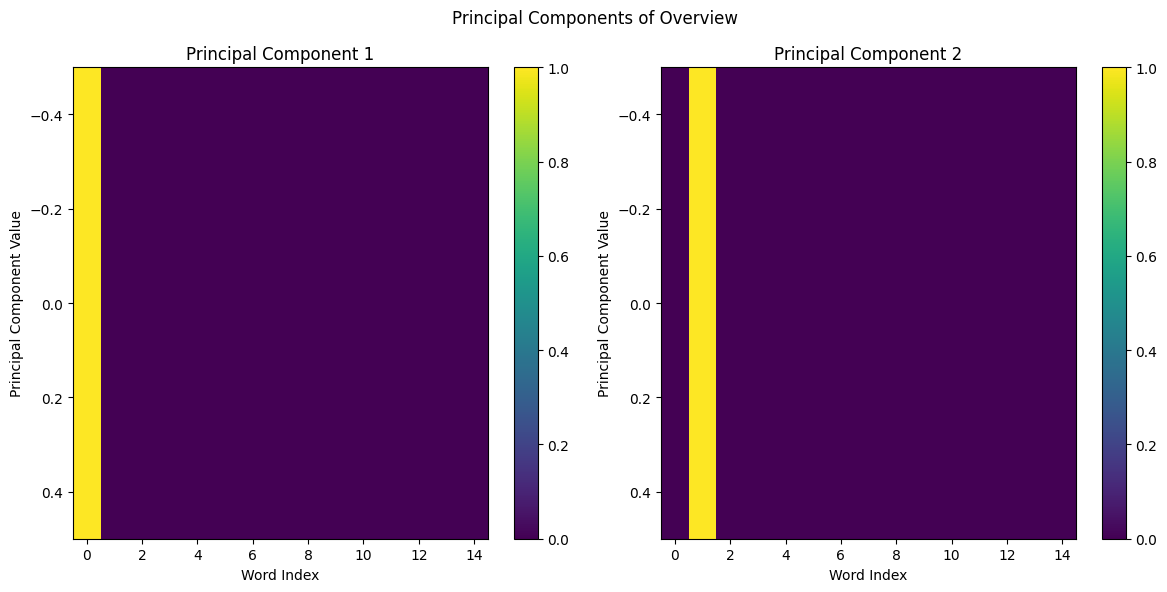

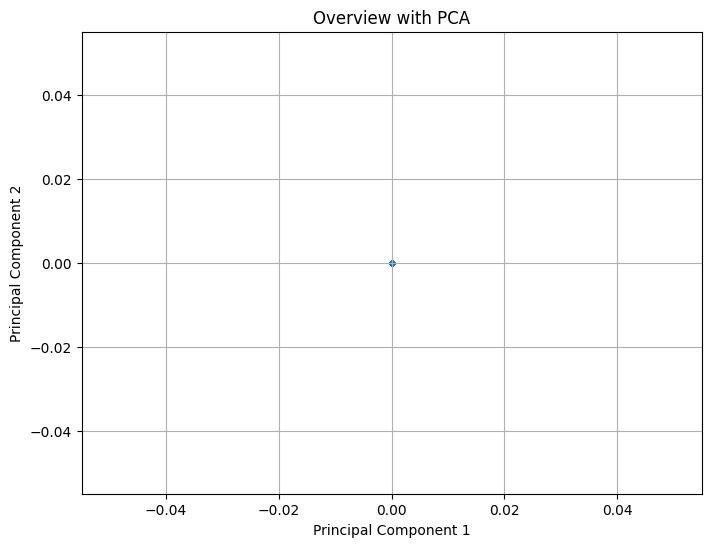

In [20]:
# import PCA decomposition class from sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
overview_pca = pca.fit_transform(df['one_hot_overview'].to_list())

# Plot the principal components
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for i, c in enumerate(pca.components_):
    pos = ax[i].imshow(c.reshape(1, -1), aspect='auto')
    plt.colorbar(pos, ax=ax[i])
    ax[i].set_title(f"Principal Component {i+1}")
    ax[i].set_xlabel('Word Index')
    ax[i].set_ylabel('Principal Component Value')

plt.suptitle('Principal Components of Overview')
plt.tight_layout()
plt.show()

# Plot the transformed data points
plt.figure(figsize=(8, 6))
plt.scatter(overview_pca[:, 0], overview_pca[:, 1], alpha=0.5, s=10)
plt.title('Overview with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()
# we did exactly this in the lecture notebook

**Q3.2** Do you see any interpretable structure in the above plot ("interpretable" $\rightarrow$ the patterns are explainable).



I do not understand how to implement PCA, why do I need to reshape the data.

**Q3.3** Quantify how much variance information a 2D PCA projection loses for this dataset.

I gave up from here onwards.

**Q3.4** Plot a line graph where the y-axis is cumulative explained variance ratio and the x-axis is the number of PCA components.

In [ ]:
# Set up PCA object with the desired number of components

# fit transform one_hot_overview encodings
labels_pca = ...
# get explained variance ratio from object, store it in a list
...

plt.plot(...)
# set up y label, x label, title
plt.show()

**Q3.5** How many principal components do you need in order to explain 80% of the total variance in the data?

Note: don't just estimate it by eye, write some code to compute it for you.

In [ ]:
# your code answer here

*Your text answer here*

**Q3.6** Using the number of dimensions you found in Q3.5, fit and transform your overview encodings using PCA and add it to a new column called `overview_pca` in the dataframe.

In [ ]:
n_dims = ...
pca = ...
labels_pca = ...
df["overview_pca"] = ...

# Q4 K-Means Clustering

**Q4.1** Cluster the movies based on the features that were extracted via PCA in the last step. Set $K=20$. Add the predicted cluster into the dataframe as a new column called `cluster_kmeans`. Print out the elements of cluster number 0 from the dataframe.

In [ ]:
# import KMeans class
from sklearn.cluster import KMeans

# Perform K-means clustering
kmeans = ...
# fit model
...

y_preds = # get predictions
df["cluster_kmeans"] = ... # set predictions

# print out elements of cluster 0
...

**Q4.2** Does this clustering seem alright to you (based on your movie watching history)? Are there movies that go well together and movies that don't?

*Your text answer here*

**Q4.3** Now, we'll figure out whether using the elbow method is right for this dataset. Plot a loss (using `kmeans.inertia_`) versus cluster size plot. Is there an elbow that you see clearly? What cluster size would you choose?

*Your text answer here*

In [ ]:
... # your code answer here

# Q5 Gaussian Mixture Models

**Q5.1** As with the K-means above, cluster the movies based on the features that were extracted via PCA in a previous step. Set $K=20$. Add the predicted cluster into the dataframe as a new column called `cluster_gmm`. Print out the elements of a single cluster of your choice from the dataframe.

In [ ]:
# Your code answer here

**Q4.2** Does this clustering seem alright to you (based on your movie watching history)? Are there movies that go well together and movies that don't? How does this compare to K-Means Clustering?

*Your text answer here*

**Q4.3** Let's check out the size of the clusters. Create a double bar plot (**as you did in the last assignment**) showing the different sizes of the clusters.

*Hint: you may want to consider `df.value_counts()` if you're unfamiliar.*

In [ ]:
# Create an array for the x-axis positions
# Plotting the bars
# Add labels, title, and legend

**Q4.4** Do you see a significant difference in the sizes of the clusters? Which is more uniform? Any thought on why?

*Your text answer here*

# Q6: A very simple recommender system

One useful thing that clustering is often used for (though at a much greater complexity) is in **recommender systems**. These are systems with users and items (movies, files, documents, etc.), where new items are shown to the user based on what they've previously interacted with, and possibly also on the behaviour of other users.

**Q6.1** Assume your dentist has just watched the movie Avatar and asks you for a recommendation. Lucky for you, you just finished this assignment. Using the cluster indices of the movie Avatar for both the K-means and GMM methods, print out suggestions for new movies.

In [ ]:
prev_watch = "Avatar"

cluster_kmeans = # find what cluster index Avatar falls into for k-means
cluster_gmm = # find what cluster index Avatar falls into for gmm

# print out similar movies
...

**Q6.2** Are any of the two recommender systems any good? Would you use them if your real dentist asks for a movie suggestion?

*Your text answer here*

**Q6.3** How would you try making the recommender systems better?

*Your text answer here*

**Q6.4** Say your dentist likes the movies you suggested and has watched a few more since you met him last. How would you incorporate this fact (recommendation based on multiple movies) into your suggestions?

*Your text answer here*

**Q6.5** An alternative method for recommendations is to use your encoded movie-feature vectors (in this case your overview+PCA vector) in order to find out what movie may be most similar to the current one. In the case of K-Means and GMMs, "similarity" referred to Euclidean distance. However, in this exercise, we will use *cosine similarity*, which is another very common similarity measure, and is related to the angle between two vectors. It is defined as:

$$sim(v_1, v_2)=\frac{v_1\cdot v_2}{||v_1||\cdot||v_2||}$$

Where $v_1$ and $v_2$ are vectors and the operator $||\cdot||$ is the norm of the vector. The function ranges from $[-1,1]$ (where 1 means that the vectors point in the same direction).

Define an appropriate function `cosine_sim`. Add a column called `cos_sim_to_avatar` in the df and print out the head of the df, sorted by the similarity. What movies would you recommend now? Is this better than the clustering methods?

In [ ]:
def cosine_sim(v1, v2):
    return ...

# get overview_pca encoding of previously watched film
prev_watch_enc = ...

sims = [] # set up place to store similarities
for i, row in df.iterrows():
    sims.append(...)

df["cos_sim_to_avatar"] = ...
df = df.sort_values(...) # sort df
df # print to verify

*Your text answer here*

# Q7 Unsupervised Learning as a Tool

At the end of this brief forey into natural language processing, we will end with an interesting task: can a machine predict the genre of a movie based purely on the first 10 words of its overview?

First, the following cell shuffles the dataset and splits it into a training and test set. The random seed and random state ensure that the train and test samples are the same for you all the time, and *probably* your classmates too. You can verify this by printing out the dataframes and checking it for yourself.

In [ ]:
np.random.seed(0)
n_train = int(0.8*len(df))
df_shuffle = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_train = df_shuffle[:n_train].reset_index(drop=True)
df_test = df_shuffle[n_train:].reset_index(drop=True)
print(len(df_train), len(df_test))

## Train, test, evaluate

Using a supervised learning method of your choice, try predicting the genre of a movie from the overview. The way you preprocess your data is up to you, and you can take inspiration from the above exercises (e.g. PCA on the one-hot encodings as input, one-hot label encodings as output). There are a number of hyperparameters you can choose depending on your selected method (number of words in your overview, number of dimensions, number of clusters, hyperparameters of your supervised model...), thus, make sure to perform hyperparameter optimization in some way (grid-search, fine-tuning, etc). Once you are happy with how your model is performing, **print out the train_score (accuracy$\in[0,1]$), test_score (accuracy$\in[0,1]$), mean training time (in seconds), and mean inference time (in seconds) of your model**.

If you are already excited about neural networks, you may also choose to use that as your supervised method. The easiest way to do it is with sklearn's `MLPClassifier` module. The main hyperparameter you would need to tune is the architecture of your model -- how many hidden layers, and how large is each one. For this task, in order to get best performance, you do not necessarily need an MLP (multi-layer perceptron) but feel free to experiment.

*Hint: the `train_and_eval` function from the last assignment should be of great help here*

In [ ]:
# your code here: feel free to add extra cells

Write a paragraph of ~150 words about how you went about selecting and tuning your model, and how you may want to make improvements to your model if you were to continue working on this. Plots are very good but not strictly necessary (i.e. try to add plots if you can).

*Your text answer here*

# BONUS

If you are happy with your score and wish to see how well it is doing with respect to other people (a sort of mini-competition), fill out the following form with the train_score (accuracy$\in[0,1]$), test_score (accuracy$\in[0,1]$), mean training time (in seconds), and mean inference time (in seconds) of your model, as well as what method you use. You can submit as many times before the deadline as you wish. Your final results will be correlated with your submission in order to validate your results (if we cannot validate them, they will be immediately disqualified).

[FORM HERE](https://forms.gle/rXRtXScABH5oDLRWA)